Generated: fig_ablation_latency_bold.pdf


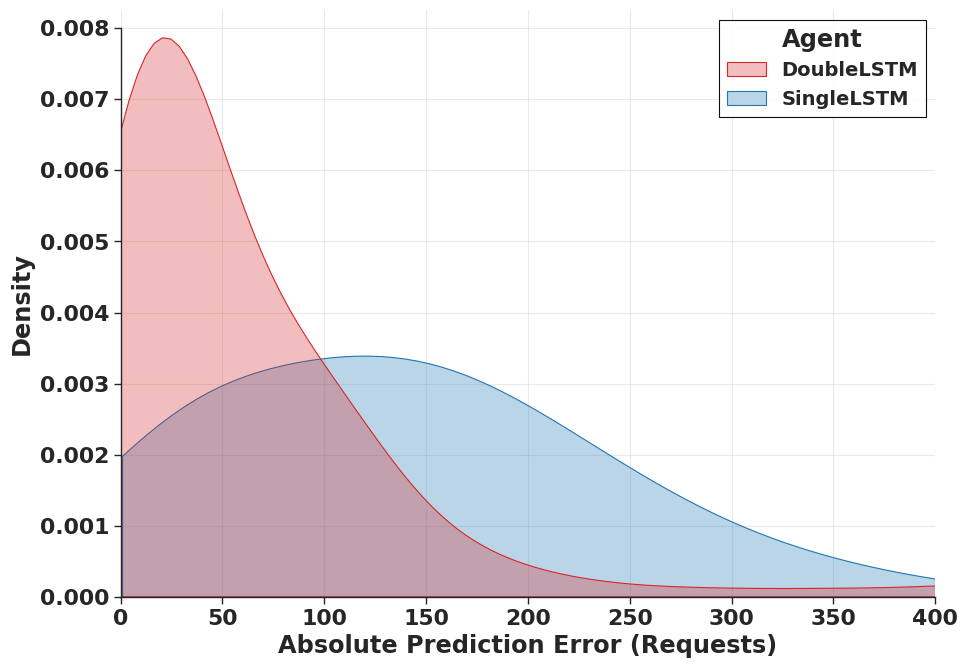

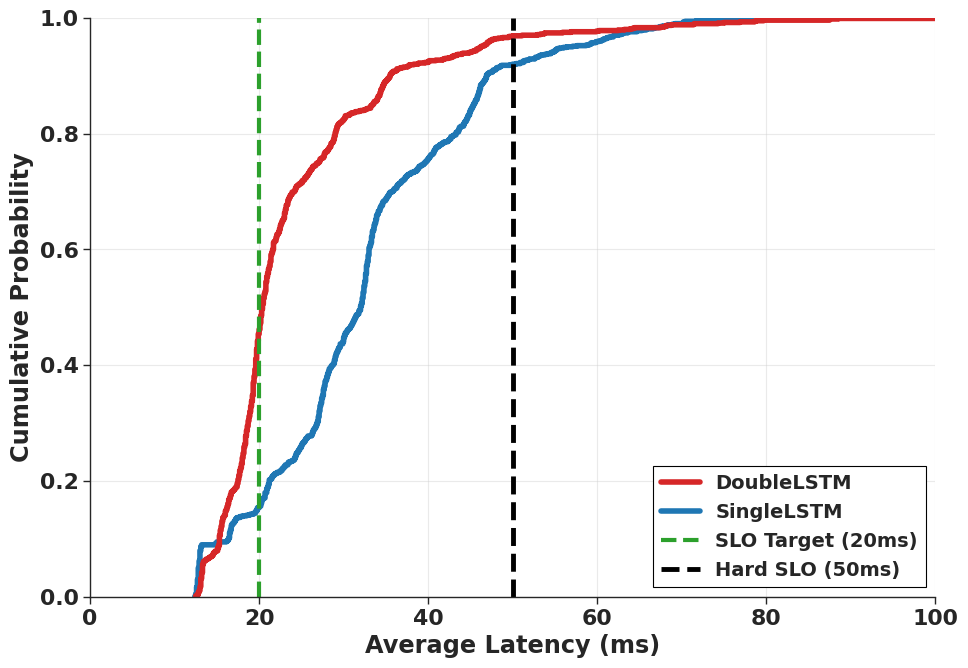

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from matplotlib.lines import Line2D  # Added for custom legend

# ==========================================
# 1. PUBLICATION CONFIGURATION
# ==========================================
CONFIG = {
    'files': {
        'DoubleLSTM': 'test_log_20251225-123638.csv',
        'SingleLSTM': 'test_log_aggarwal_20251204-114951.csv'
    },
    'colors': {
        'DoubleLSTM': '#d62728',  # Proposed (Red)
        'SingleLSTM': '#1f77b4',  # Baseline (Blue)
    },
    'slo_target': 20,
    'slo_hard': 50,
    'dpi': 600
}

# Set professional bold aesthetics
sns.set_theme(style="ticks", context="paper", font_scale=1.8)
plt.rcParams.update({
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'axes.grid': True,
    'grid.alpha': 0.4,
    'lines.linewidth': 3.5,
    'legend.frameon': True,
    'legend.edgecolor': 'black',
    'legend.fontsize': 14
})

# ==========================================
# 2. DATA PROCESSING
# ==========================================
def process_dataframe(df, agent_name):
    df = df.copy()
    df['Agent'] = agent_name
    if 'Forecast' in df.columns and 'Requests' in df.columns:
        # Calculate error relative to raw trace
        multiplier = df['Throughput'] if 'Throughput' in df.columns else 1.0
        raw_reqs = df['Requests'] / multiplier.replace(0, 1)
        df['Forecast_Error'] = (df['Forecast'] - raw_reqs).abs()
    return df

def load_data(config):
    dfs = []
    for agent, filepath in config['files'].items():
        if os.path.exists(filepath):
            raw_df = pd.read_csv(filepath)
            dfs.append(process_dataframe(raw_df, agent))
    return pd.concat(dfs, ignore_index=True) if dfs else None

# ==========================================
# 3. PLOTTING
# ==========================================
def plot_ablation_results(df):
    # --- FIGURE A: FORECAST ERROR DISTRIBUTION ---
    plt.figure(figsize=(10, 7))
    ax1 = sns.kdeplot(data=df, x='Forecast_Error', hue='Agent', fill=True,
                      palette=CONFIG['colors'], common_norm=False, cut=0, alpha=0.3)
    plt.xlabel('Absolute Prediction Error (Requests)', fontweight='bold')
    plt.ylabel('Density', fontweight='bold')
    plt.xlim(0, 400)
    sns.despine(trim=True)
    plt.tight_layout()
    plt.savefig('fig_ablation_forecast_bold.pdf', bbox_inches='tight')

    # --- FIGURE B: LATENCY CDF (With SLO & Hard SLO) ---
    plt.figure(figsize=(10, 7))
    ax2 = plt.gca()

    # ECDF Plot (We turn off Seaborn's default legend so we can build our own)
    sns.ecdfplot(data=df, x='Latency_Avg', hue='Agent',
                 palette=CONFIG['colors'], linewidth=4, ax=ax2, legend=False)

    # 1. SLO Target (20ms) - Dashed Green
    ax2.axvline(
        CONFIG['slo_target'],
        color='#2ca02c', # Sharp Green
        linestyle='--',
        linewidth=3
    )

    # 2. Hard SLO Threshold (50ms) - Sharp Solid Black
    ax2.axvline(
        CONFIG['slo_hard'],
        color='#000000', # Sharp Black
        linestyle='--',
        linewidth=3.5
    )

    plt.xlabel('Average Latency (ms)', fontweight='bold')
    plt.ylabel('Cumulative Probability', fontweight='bold')
    plt.xlim(0, 100)

    # ==========================================
    # ROBUST CUSTOM LEGEND
    # ==========================================
    custom_lines = [
        Line2D([0], [0], color=CONFIG['colors']['DoubleLSTM'], lw=4, label='DoubleLSTM'),
        Line2D([0], [0], color=CONFIG['colors']['SingleLSTM'], lw=4, label='SingleLSTM'),
        Line2D([0], [0], color='#2ca02c', linestyle='--', lw=3, label=f'SLO Target ({CONFIG["slo_target"]}ms)'),
        Line2D([0], [0], color='#000000', linestyle='--', lw=3.5, label=f'Hard SLO ({CONFIG["slo_hard"]}ms)')
    ]

    leg = ax2.legend(handles=custom_lines, loc='lower right', framealpha=1)
    for text in leg.get_texts():
        text.set_fontweight('bold')

    sns.despine(trim=True)
    plt.tight_layout()
    plt.savefig('fig_ablation_latency_bold.pdf', bbox_inches='tight')
    print("Generated: fig_ablation_latency_bold.pdf")

if __name__ == "__main__":
    df = load_data(CONFIG)
    if df is not None:
        plot_ablation_results(df)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

plt.rcParams.update({
    'font.size': 18,               # Large base font
    'font.weight': 'bold',         # Global bold text
    'axes.labelweight': 'bold',    # Bold X and Y labels
    'axes.labelsize': 22,          # Very large labels
    'xtick.labelsize': 16,         # Readable tick numbers
    'ytick.labelsize': 16,
    'legend.fontsize': 16,         # Slightly smaller legend font to fit better
    'legend.frameon': True,
    'legend.edgecolor': 'black',
    'lines.linewidth': 3.0,        # Thick lines for visibility
})

# Agent files and labels
files = {
    '/content/static_benchmark_20251214-155557.csv': 'StaticHPA50',
    '/content/dqn_test_log_20260218-093114.csv': 'DDQN',
    '/content/test_log_aggarwal_20251204-114951.csv': 'SingleLSTM',
    '/content/test_log_20251225-123638.csv': 'DoubleLSTM'
}

# Distinct, high-contrast colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # blue, orange, green, red

metrics = ['Replicas', 'CPU_Pct', 'Latency_Avg', 'Latency_P90']
y_labels = ['Replica Count', 'CPU Utilization (%)', 'Average Latency (ms)', '90th Percentile Latency (ms)']

# Create 4 separate figures (one per metric)
for i, (metric, y_label) in enumerate(zip(metrics, y_labels)):
    fig, ax = plt.subplots(figsize=(14, 7))

    for j, (file, agent) in enumerate(files.items()):
        if os.path.exists(file):
            df = pd.read_csv(file)
            ax.plot(df['Step'], df[metric], label=agent, color=colors[j], alpha=0.95)

    ax.set_xlabel('Time Step', fontweight='bold')
    ax.set_ylabel(y_label, fontweight='bold')

    # Grid and Border settings
    ax.grid(True, linestyle='--', alpha=0.7, linewidth=1.5)
    for spine in ax.spines.values():
        spine.set_linewidth(2)

    leg = ax.legend(loc='best', framealpha=0.7, edgecolor='black', ncol=2)

    for text in leg.get_texts():
        text.set_fontweight('bold')

    plt.tight_layout()

    save_path = f'{metric.lower()}_comparison_final.pdf'
    plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.close()
    print(f"✓ Generated: {save_path}")

print("\nFinal figures generated with dynamic legend placements and transparency.")

✓ Generated: replicas_comparison_final.pdf
✓ Generated: cpu_pct_comparison_final.pdf
✓ Generated: latency_avg_comparison_final.pdf
✓ Generated: latency_p90_comparison_final.pdf

Final figures generated with dynamic legend placements and transparency.



=== REVIEWER REQUESTED TABLE ===
| Agent      |   Avg CPU (%) |   Avg Latency (ms) |   Missed SLO (Fraction) | Missed SLO (%)   |
|:-----------|--------------:|-------------------:|------------------------:|:-----------------|
| DoubleLSTM |         38.22 |              24.11 |                   0.538 | 53.8%            |
| SingleLSTM |         31    |              32.37 |                   0.844 | 84.4%            |
| DDQN       |         87.29 |              77.33 |                   0.91  | 91.0%            |
| StaticHPA  |         15.44 |              58.82 |                   0.897 | 89.7%            |

LaTeX Code:
\begin{table}
\caption{Performance Summary: Resource usage and SLO compliance.}
\begin{tabular}{lllll}
\toprule
Agent & Avg CPU (%) & Avg Latency (ms) & Missed SLO (Fraction) & Missed SLO (%) \\
\midrule
DoubleLSTM & 38.22 & 24.11 & 0.538 & 53.8% \\
SingleLSTM & 31.00 & 32.37 & 0.844 & 84.4% \\
DDQN & 87.29 & 77.33 & 0.910 & 91.0% \\
StaticHPA & 15.44 & 58.82 & 0.897 &

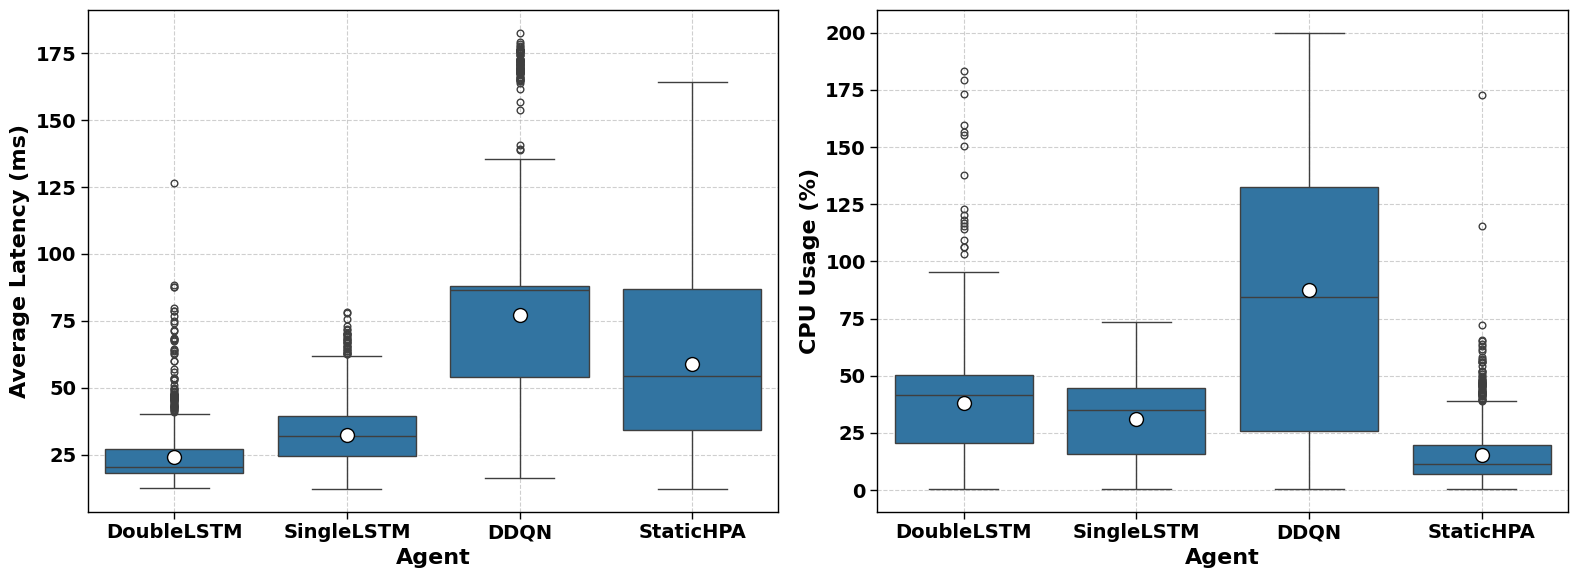

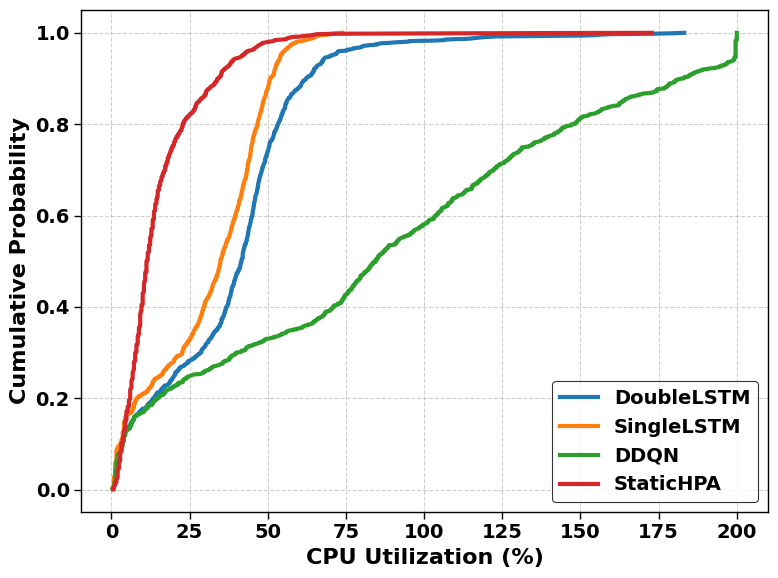

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ==========================================
# 1. CONFIGURATION
# ==========================================
CONFIG = {
    'files': {
        'DoubleLSTM': '/content/test_log_20251225-123638.csv',
        'SingleLSTM': '/content/test_log_aggarwal_20251204-114951.csv',
        'DDQN': '/content/dqn_test_log_20260218-093114.csv',
        'StaticHPA': '/content/static_benchmark_20251214-155557.csv'
    },
    'sla_threshold': 20,     # The SLO target (ms)
    'font_scale': 1.5,       # INCREASING FONT SIZE FOR REVIEWER
    'warmup_steps': 50       # Optional: Skip first N steps if cold start is too skewed
}

# Apply global font increase
sns.set_context("paper", font_scale=CONFIG['font_scale'])
plt.rcParams.update({'font.size': 14, 'axes.labelsize': 16, 'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.fontsize': 14})

# ==========================================
# 2. DATA PROCESSING
# ==========================================
def load_data():
    dfs = []
    for agent, fpath in CONFIG['files'].items():
        if os.path.exists(fpath):
            df = pd.read_csv(fpath)
            # Basic cleanup
            df['Agent'] = agent
            cols = ['Replicas', 'CPU_Pct', 'Latency_Avg']
            for c in cols:
                if c in df.columns:
                    df[c] = pd.to_numeric(df[c], errors='coerce')

            # Filter out warmup if needed to make boxplots cleaner
            # df = df.iloc[CONFIG['warmup_steps']:]

            dfs.append(df)
    return pd.concat(dfs, ignore_index=True) if dfs else None

df = load_data()

# ==========================================
# 3. GENERATE THE REQUESTED TABLE
# ==========================================
def generate_summary_table(df):
    summary = []
    for agent in df['Agent'].unique():
        d = df[df['Agent'] == agent]

        # Calculate metrics
        avg_cpu = d['CPU_Pct'].mean()
        avg_lat = d['Latency_Avg'].mean()

        # Fraction of Missed Calls (SLO Violations)
        missed = d[d['Latency_Avg'] > CONFIG['sla_threshold']]
        fraction_missed = len(missed) / len(d)

        summary.append({
            'Agent': agent,
            'Avg CPU (%)': f"{avg_cpu:.2f}",
            'Avg Latency (ms)': f"{avg_lat:.2f}",
            'Missed SLO (Fraction)': f"{fraction_missed:.3f}", # e.g., 0.150
            'Missed SLO (%)': f"{fraction_missed*100:.1f}%"
        })

    summ_df = pd.DataFrame(summary)
    print("\n=== REVIEWER REQUESTED TABLE ===")
    print(summ_df.to_markdown(index=False))
    print("\nLaTeX Code:")
    print(summ_df.to_latex(index=False, caption="Performance Summary: Resource usage and SLO compliance."))

# ==========================================
# 4. GENERATE THE REQUESTED PLOTS
# ==========================================

def plot_boxplots(df):
    """
    Boxplots for Latency and CPU with Mean markers.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # --- Latency Boxplot ---
    sns.boxplot(data=df, x='Agent', y='Latency_Avg', ax=axes[0], showmeans=True,
                meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"10"})
    #axes[0].set_title("Latency Distribution (Lower is Better)")
    axes[0].set_ylabel("Average Latency (ms)")
    axes[0].grid(True, linestyle='--', alpha=0.6)

    # --- CPU Boxplot ---
    sns.boxplot(data=df, x='Agent', y='CPU_Pct', ax=axes[1], showmeans=True,
                meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"10"})
    #axes[1].set_title("CPU Utilization Distribution (Higher is Efficient)")
    axes[1].set_ylabel("CPU Usage (%)")
    axes[1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.savefig("boxplot_latency_cpu.pdf") # PDF is better for papers
    plt.show()

def plot_cpu_cdf(df):
    """
    CDF of CPU Consumption.
    """
    plt.figure(figsize=(8, 6))
    for agent in df['Agent'].unique():
        d = df[df['Agent'] == agent]['CPU_Pct'].dropna().sort_values()
        y = np.arange(1, len(d)+1) / len(d)
        plt.plot(d, y, label=agent, linewidth=3) # Thicker lines

    #plt.title("CDF of CPU Consumption")
    plt.xlabel("CPU Utilization (%)")
    plt.ylabel("Cumulative Probability")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig("cdf_cpu.pdf")
    plt.show()

# Run the functions
if df is not None:
    generate_summary_table(df)
    plot_boxplots(df)
    plot_cpu_cdf(df)

                  PERFORMANCE SUMMARY TABLE                 
      Agent  Average CPU (%)  Average Latency (ms)  Fraction of Missed Calls
StaticHPA50            15.44                 58.82                     0.565
        DQN            87.29                 77.33                     0.754
 SingleLSTM            31.00                 32.37                     0.080
 DoubleLSTM            38.22                 24.11                     0.031

✓ Saved table to 'performance_summary_table.csv'
✓ Generated: fig_cpu_cdf_bold.pdf


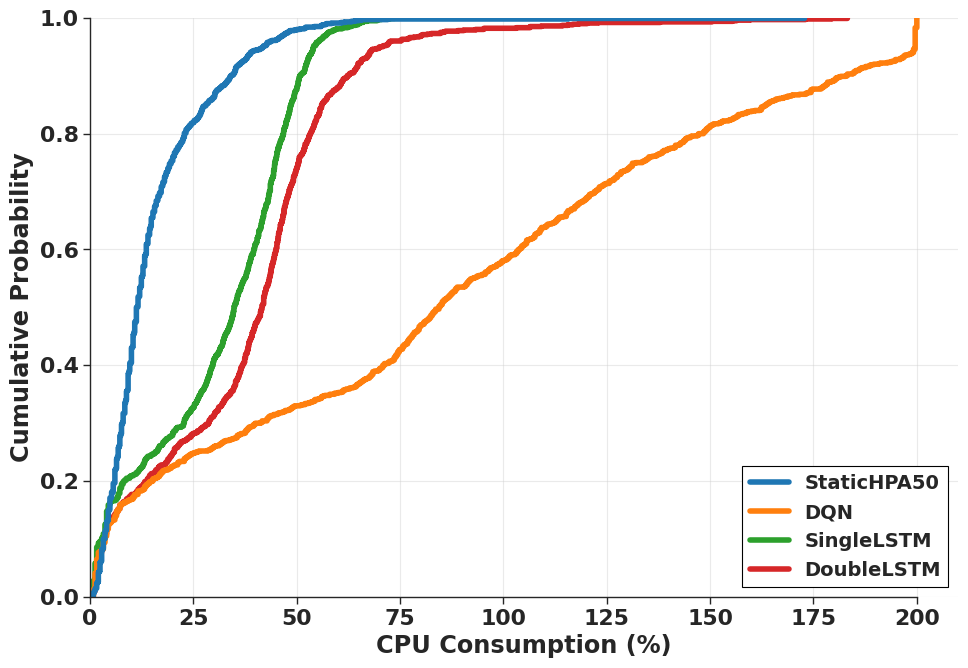

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from matplotlib.lines import Line2D

# ==========================================
# 1. PUBLICATION CONFIGURATION
# ==========================================
CONFIG = {
    'files': {
        'StaticHPA50': '/content/static_benchmark_20251214-155557.csv',
        'DQN': '/content/dqn_test_log_20260218-093114.csv',
        'SingleLSTM': '/content/test_log_aggarwal_20251204-114951.csv',
        'DoubleLSTM': '/content/test_log_20251225-123638.csv'
    },
    'colors': {
        'StaticHPA50': '#1f77b4',  # Baseline (Blue)
        'DQN': '#ff7f0e',          # Baseline (Orange)
        'SingleLSTM': '#2ca02c',   # Baseline (Green)
        'DoubleLSTM': '#d62728',   # Proposed (Red)
    },
    'hard_slo': 50, # Threshold for defining "missed calls" (ms)
    'dpi': 600
}

# Set professional bold aesthetics
sns.set_theme(style="ticks", context="paper", font_scale=1.8)
plt.rcParams.update({
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'axes.grid': True,
    'grid.alpha': 0.4,
    'lines.linewidth': 3.5,
    'legend.frameon': True,
    'legend.edgecolor': 'black',
    'legend.fontsize': 14
})

# ==========================================
# 2. DATA PROCESSING & TABLE GENERATION
# ==========================================
def process_data_and_table(config):
    dfs = []
    table_data = []

    for agent, filepath in config['files'].items():
        if os.path.exists(filepath):
            df = pd.read_csv(filepath)
            df['Agent'] = agent
            dfs.append(df)

            # --- CALCULATE TABLE METRICS ---
            avg_cpu = df['CPU_Pct'].mean() if 'CPU_Pct' in df.columns else np.nan
            avg_lat = df['Latency_Avg'].mean() if 'Latency_Avg' in df.columns else np.nan

            # Define 'Missed Calls' Fraction:
            # If dataset has a 'Errors' column, calculate based on that.
            # Otherwise, use SLA Violations (Latency > Hard SLO) as a fallback proxy.
            if 'Errors' in df.columns and 'Requests' in df.columns:
                missed_fraction = (df['Errors'] / df['Requests'].replace(0, 1)).mean()
            else:
                missed_calls = (df['Latency_Avg'] > config['hard_slo']).sum()
                total_calls = len(df)
                missed_fraction = missed_calls / total_calls if total_calls > 0 else 0

            table_data.append({
                'Agent': agent,
                'Average CPU (%)': round(avg_cpu, 2),
                'Average Latency (ms)': round(avg_lat, 2),
                'Fraction of Missed Calls': round(missed_fraction, 4)
            })

    # Print the DataFrame table neatly
    if table_data:
        summary_df = pd.DataFrame(table_data)
        print("============================================================")
        print("                  PERFORMANCE SUMMARY TABLE                 ")
        print("============================================================")
        print(summary_df.to_string(index=False))
        print("============================================================\n")

        # Save to CSV for easy copy/pasting
        summary_df.to_csv('performance_summary_table.csv', index=False)
        print("✓ Saved table to 'performance_summary_table.csv'")

    return pd.concat(dfs, ignore_index=True) if dfs else None

# ==========================================
# 3. PLOTTING CPU CDF
# ==========================================
def plot_cpu_cdf(df, config):
    plt.figure(figsize=(10, 7))
    ax = plt.gca()

    # ECDF Plot (Turn off Seaborn's default legend to build our robust custom one)
    sns.ecdfplot(
        data=df,
        x='CPU_Pct',
        hue='Agent',
        palette=config['colors'],
        linewidth=4,
        ax=ax,
        legend=False
    )

    plt.xlabel('CPU Consumption (%)', fontweight='bold')
    plt.ylabel('Cumulative Probability', fontweight='bold')

    # Dynamically scale X-axis (ensure at least 0-100% is visible, or larger if spikes exist)
    max_cpu = df['CPU_Pct'].max()
    plt.xlim(0, max(100, max_cpu + 10))

    # ==========================================
    # ROBUST CUSTOM LEGEND
    # ==========================================
    custom_lines = [
        Line2D([0], [0], color=config['colors']['StaticHPA50'], lw=4, label='StaticHPA50'),
        Line2D([0], [0], color=config['colors']['DQN'], lw=4, label='DQN'),
        Line2D([0], [0], color=config['colors']['SingleLSTM'], lw=4, label='SingleLSTM'),
        Line2D([0], [0], color=config['colors']['DoubleLSTM'], lw=4, label='DoubleLSTM')
    ]

    leg = ax.legend(handles=custom_lines, loc='lower right', framealpha=1)
    for text in leg.get_texts():
        text.set_fontweight('bold')

    sns.despine(trim=True)
    plt.tight_layout()
    plt.savefig('fig_cpu_cdf_bold.pdf', bbox_inches='tight')
    print("✓ Generated: fig_cpu_cdf_bold.pdf")

# ==========================================
# 4. EXECUTION
# ==========================================
if __name__ == "__main__":
    all_data = process_data_and_table(CONFIG)
    if all_data is not None:
        plot_cpu_cdf(all_data, CONFIG)
    else:
        print("No valid CSV files found in the specified paths.")

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from matplotlib.lines import Line2D

# ==========================================
# 1. PUBLICATION CONFIGURATION
# ==========================================
CONFIG = {
    'files': {
        'StaticHPA50': '/content/static_benchmark_20251214-155557.csv',
        'DQN': '/content/dqn_test_log_20260218-093114.csv',
        'SingleLSTM': '/content/test_log_aggarwal_20251204-114951.csv',
        'DoubleLSTM': '/content/test_log_20251225-123638.csv'
    },
    'colors': {
        'StaticHPA50': '#1f77b4',  # Baseline (Blue)
        'DQN': '#ff7f0e',          # Baseline (Orange)
        'SingleLSTM': '#2ca02c',   # Baseline (Green)
        'DoubleLSTM': '#d62728',   # Proposed (Red)
    },
    'target_slo': 20, # 20ms Target SLO
    'hard_slo': 50,   # 50ms Hard SLO (for Missed Calls)
    'dpi': 600
}

# Set professional bold aesthetics
sns.set_theme(style="ticks", context="paper", font_scale=1.8)
plt.rcParams.update({
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'axes.grid': True,
    'grid.alpha': 0.4,
    'lines.linewidth': 3.5,
    'legend.frameon': True,
    'legend.edgecolor': 'black',
    'legend.fontsize': 14
})

# ==========================================
# 2. DATA PROCESSING & TABLE GENERATION
# ==========================================
def process_data_and_table(config):
    dfs = []
    table_data = []

    for agent, filepath in config['files'].items():
        if os.path.exists(filepath):
            df = pd.read_csv(filepath)
            df['Agent'] = agent
            dfs.append(df)

            # --- CALCULATE TABLE METRICS ---
            avg_cpu = df['CPU_Pct'].mean() if 'CPU_Pct' in df.columns else np.nan
            avg_lat = df['Latency_Avg'].mean() if 'Latency_Avg' in df.columns else np.nan

            total_calls = len(df)

            # Calculate Missed Calls and Compliance for BOTH SLOs
            if 'Latency_Avg' in df.columns and total_calls > 0:
                # Fraction missed (Hard SLO)
                missed_calls = (df['Latency_Avg'] > config['hard_slo']).sum()
                missed_fraction = missed_calls / total_calls

                # Compliance percentages
                target_compliance = (df['Latency_Avg'] <= config['target_slo']).mean() * 100.0
                hard_compliance = (df['Latency_Avg'] <= config['hard_slo']).mean() * 100.0
            else:
                missed_fraction = np.nan
                target_compliance = np.nan
                hard_compliance = np.nan

            table_data.append({
                'Agent': agent,
                'Average CPU (%)': round(avg_cpu, 2),
                'Average Latency (ms)': round(avg_lat, 2),
                'Fraction Missed Calls': round(missed_fraction, 4),
                'Target SLO Compliance (%)': round(target_compliance, 2),
                'Hard SLO Compliance (%)': round(hard_compliance, 2)
            })

    # Print and Save DataFrame table
    if table_data:
        summary_df = pd.DataFrame(table_data)
        print("=================================================================================================")
        print("                                     PERFORMANCE SUMMARY TABLE                                   ")
        print("=================================================================================================")
        print(summary_df.to_string(index=False))
        print("=================================================================================================\n")

        summary_csv_path = 'performance_summary_table.csv'
        summary_df.to_csv(summary_csv_path, index=False)
        print(f"✓ Saved table to: {summary_csv_path}")

    return pd.concat(dfs, ignore_index=True) if dfs else None

# ==========================================
# 3. PLOTTING CPU CDF
# ==========================================
def plot_cpu_cdf(df, config):
    plt.figure(figsize=(10, 7))
    ax = plt.gca()

    sns.ecdfplot(
        data=df, x='CPU_Pct', hue='Agent',
        palette=config['colors'], linewidth=4, ax=ax, legend=False
    )

    plt.xlabel('CPU Consumption (%)', fontweight='bold')
    plt.ylabel('Cumulative Probability', fontweight='bold')

    max_cpu = df['CPU_Pct'].max()
    plt.xlim(0, max(100, max_cpu + 10))

    # Robust Custom Legend
    custom_lines = [
        Line2D([0], [0], color=config['colors']['StaticHPA50'], lw=4, label='StaticHPA50'),
        Line2D([0], [0], color=config['colors']['DQN'], lw=4, label='DQN'),
        Line2D([0], [0], color=config['colors']['SingleLSTM'], lw=4, label='SingleLSTM'),
        Line2D([0], [0], color=config['colors']['DoubleLSTM'], lw=4, label='DoubleLSTM')
    ]

    leg = ax.legend(handles=custom_lines, loc='lower right', framealpha=1)
    for text in leg.get_texts():
        text.set_fontweight('bold')

    sns.despine(trim=True)
    plt.tight_layout()
    plt.savefig('fig_cpu_cdf_bold.pdf', bbox_inches='tight')
    plt.close()
    print("✓ Generated: fig_cpu_cdf_bold.pdf")

# ==========================================
# 4. PLOTTING BOXPLOTS
# ==========================================
# ==========================================
# 4. PLOTTING BOXPLOTS (UPDATED)
# ==========================================
def plot_boxplots(df, config):
    metrics = {
        'CPU_Pct': 'CPU Utilization (%)',
        'Latency_Avg': 'Average Latency (ms)',
        'Latency_P90': '90th Percentile Latency (ms)',
        'Replicas': 'Replica Count'
    }

    for metric, ylabel in metrics.items():
        if metric in df.columns:
            plt.figure(figsize=(10, 7))

            # CHANGED: showfliers=True restores the true maximums!
            # flierprops makes the outliers small, transparent dots so they don't ruin the box
            sns.boxplot(
                data=df, x='Agent', y=metric,
                palette=config['colors'],
                showfliers=True,
                flierprops=dict(marker='o', color='black', markersize=3, alpha=0.3, markeredgecolor='none'),
                linewidth=2.5, width=0.6
            )

            plt.xlabel('Agent', fontweight='bold')
            plt.ylabel(ylabel, fontweight='bold')

            # Automatically draw a Hard SLO line reference for latency graphs
            if 'Latency' in metric:
                plt.axhline(
                    config['hard_slo'], color='#000000', linestyle='--',
                    linewidth=3.5, label=f"Hard SLO ({config['hard_slo']}ms)"
                )
                leg = plt.legend(loc='upper right', framealpha=1)
                for text in leg.get_texts(): text.set_fontweight('bold')

            sns.despine(trim=True)
            plt.tight_layout()

            out_file = f'fig_boxplot_{metric.lower()}.pdf'
            plt.savefig(out_file, bbox_inches='tight')
            plt.close()
            print(f"✓ Generated Corrected Boxplot: {out_file}")

# ==========================================
# 5. EXECUTION
# ==========================================
if __name__ == "__main__":
    all_data = process_data_and_table(CONFIG)
    if all_data is not None:
        plot_cpu_cdf(all_data, CONFIG)
        plot_boxplots(all_data, CONFIG)
        print("\nAll figures generated successfully!")
    else:
        print("No valid CSV files found in the specified paths.")

                                     PERFORMANCE SUMMARY TABLE                                   
      Agent  Average CPU (%)  Average Latency (ms)  Fraction Missed Calls  Target SLO Compliance (%)  Hard SLO Compliance (%)
StaticHPA50            15.44                 58.82                  0.565                       10.3                     43.5
        DQN            87.29                 77.33                  0.754                        9.0                     24.6
 SingleLSTM            31.00                 32.37                  0.080                       15.6                     92.0
 DoubleLSTM            38.22                 24.11                  0.031                       46.2                     96.9

✓ Saved table to: performance_summary_table.csv
✓ Generated: fig_cpu_cdf_bold.pdf


/tmp/ipython-input-991226647.py:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


✓ Generated Corrected Boxplot: fig_boxplot_cpu_pct.pdf


/tmp/ipython-input-991226647.py:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


✓ Generated Corrected Boxplot: fig_boxplot_latency_avg.pdf


/tmp/ipython-input-991226647.py:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


✓ Generated Corrected Boxplot: fig_boxplot_latency_p90.pdf


/tmp/ipython-input-991226647.py:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


✓ Generated Corrected Boxplot: fig_boxplot_replicas.pdf

All figures generated successfully!
